# MNIST
## 70,000 images of digits

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
import numpy as np

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [4]:
try:
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [8]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

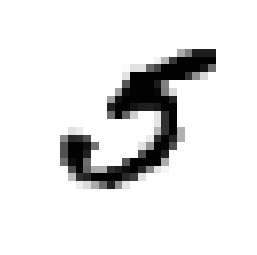

In [9]:
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

In [10]:
y[36000] # The label for the value stored at index 36000 is 5 as expected.

5

In [11]:
# Test set created:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [13]:
# Target vectors
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
# Stochastic Gradient Descent
sgd_classifier = SGDClassifier(random_state = 42)
sgd_classifier.fit(X_train, y_train_5)

/miniconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
sgd_classifier.predict([some_digit])

array([ True])

# Cross validation for performance measure

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [18]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

In [19]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_classifier)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [21]:
never_5_clf = Never5Classifier()

In [22]:
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [23]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv = 3)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [25]:
# Classifier metrics, precision and recall.
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7687135020350381

In [26]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [27]:
# Calculating the F1 score:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [28]:
y_scores = sgd_classifier.decision_function([some_digit])

In [29]:
y_scores

array([161855.74572176])

# “This confirms that raising the threshold decreases recall.”

Excerpt From: Aurélien Géron. “Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems.” iBooks. 

In [30]:
threshold = 0

In [31]:
y_some_digit_pred = (y_scores > threshold)

In [32]:
y_some_digit_pred

array([ True])

In [33]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

## Finding the best threshold to use.

In [34]:
#1
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv = 3, 
                             method = "decision_function")

In [35]:
#2
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

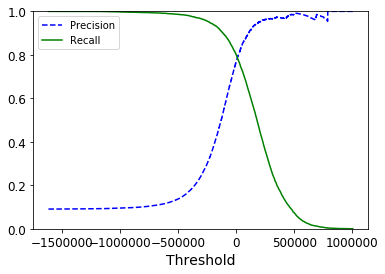

In [36]:
#3
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--",
            label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-",
            label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [37]:
y_train_pred_90 = (y_scores > 70000)

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

In [40]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

<function matplotlib.pyplot.show>

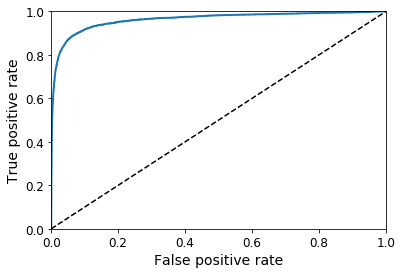

In [41]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
plot_roc_curve(fpr, tpr)
plt.show
    

In [42]:
# The higher the recall (TPR) the more (FPR) increase. 
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967156

In [43]:
from sklearn.ensemble import RandomForestClassifier
forest_classifier = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_classifier, X_train, y_train_5, cv = 3,
                                   method = "predict_proba")

/miniconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [44]:
y_scores_forest = y_probas_forest[:, 1]

In [45]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

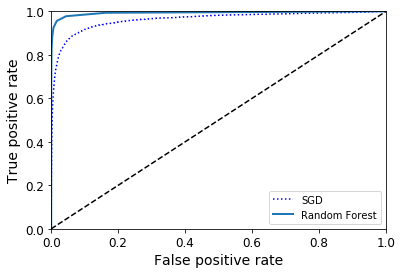

In [46]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [47]:
# The Random Forest classifier is much better than SGD, it's ROC line is closer to the top left corner.
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [49]:
# The roc_auc score is very good for random forest. 
# multi-class classification process One versus All.
sgd_classifier.fit(X_train, y_train)
sgd_classifier.predict([some_digit])

array([5], dtype=int8)

In [51]:
'''scikit-learn actually trained 10 classifiers, got their decision scores 
for the image, and selected the class with the highet score''' 
some_digit_scores = sgd_classifier.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

## Above we returned all 10 classes one per class, we can see that the multi-class classification process selected the 5th index which is `161855.74572176` the best score which is equal the 5th index `array[5]`

In [52]:
sgd_classifier.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [53]:
sgd_classifier.classes_[5]

5

#### When a classifier is trained, it stores the lsit of target classes in its `classes_` attribute, ordered by value. In this case, the index of each class in the `classes_` array conveniently matches the class itself (e.g. the 5th class matches the 5th index), but in general we won't be so lucky.

## We'll now implement the One vs One multiclass classifier

In [54]:
from sklearn.multiclass import OneVsOneClassifier
ovo_classify = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_classify.fit(X_train, y_train)
ovo_classify.predict([some_digit])

array([5], dtype=int8)

In [56]:
len(ovo_classify.estimators_)

45

In [57]:
# We train a random_forest classifier:
forest_classifier.fit(X_train, y_train)
forest_classifier.predict([some_digit])


array([5], dtype=int8)

In [58]:
forest_classifier.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [59]:
# List of probabilities that the classifier assigned to each instance for each class. 5 got 0.8 (highest)

## We can see above that the classifier also assumed the image could have been a 0 or a 3 as well but the probability for that is lower than it being a 5.

In [60]:
# Classifier evaluation:
cross_val_score(sgd_classifier, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [61]:
# We get roughly 84% on all test folds. Not bad but can be better. 

In [62]:
# We can use a scaler to scale the inputs which will increase the accuracy to above 90%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_classifier, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

# We managed to scale our X_training set and got above 90%

In [63]:
cross_val_score(forest_classifier, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.94041192, 0.93879694, 0.93949092])

In [64]:
# We can see that the random forest classifier is much better than the scaled version of SGDC. Lets see if we can improve.
cross_val_score(forest_classifier, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.94056189, 0.93909695, 0.93914087])

In [65]:
# Just a miniscule improvement, but still an improvement. 

# Error analysis

In [66]:
y_train_pred = cross_val_predict(forest_classifier, X_train_scaled, y_train, cv = 3)
con_matrix = confusion_matrix(y_train, y_train_pred)
con_matrix

array([[5805,    1,   11,    9,    8,   13,   32,    3,   38,    3],
       [   1, 6616,   39,   23,   13,    6,    9,   19,   10,    6],
       [  49,   30, 5638,   49,   47,   16,   28,   41,   53,    7],
       [  20,   17,  135, 5646,   16,  123,    7,   45,   90,   32],
       [  18,   17,   33,   11, 5526,    4,   35,   19,   26,  153],
       [  52,   21,   27,  201,   40, 4939,   43,    6,   62,   30],
       [  56,   17,   21,    9,   27,   68, 5692,    0,   24,    4],
       [  12,   39,   97,   26,   69,    9,    1, 5911,   15,   86],
       [  29,   60,   98,  153,   57,  100,   33,   15, 5229,   77],
       [  34,   18,   23,   98,  164,   45,   10,  115,   68, 5374]])

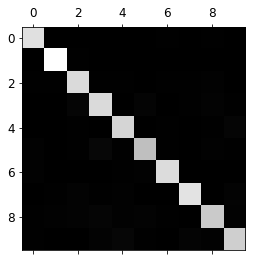

In [75]:
# Lets turn that array into a visualisation to better understand what's going on.
plt.matshow(con_matrix, cmap = plt.cm.gray)
plt.show()

In [76]:
'''Its clear that the 5's are darker than the rest, this could mean there aren't enough 5's in the dataset or the 
classifier struggles to identify 5's.''' 

u"Its clear that the 5's are darker than the rest, this could mean there aren't enough 5's in the dataset or the \nclassifier struggles to identify 5's."

## From the histogram above, the diagonal in the centre indicates the values were correctly classified. 

In [77]:
''' We need to divide each value in the confusion matrix by the number of images in the corresponding class, 
so we can compare error rates.'''
row_sums = con_matrix.sum(axis = 1, keepdims = True)
normal_con_matrix = con_matrix / row_sums

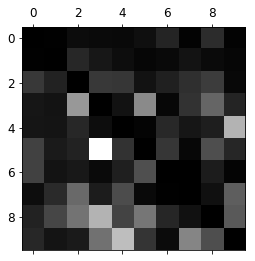

In [79]:
# Now lets fill the diagonal with zeros to keep only the errors, and lets plot the result:
np.fill_diagonal(normal_con_matrix, 0)
plt.matshow(normal_con_matrix, cmap = plt.cm.gray)
plt.show()

In [80]:
'''
Here we can see the actual errors the classifier makes, the 
- rows represent individual classes 0 to 9.
- columns represent the predicted classes 
'''

u'\nHere we can see the actual errors the classifier makes, the \n- rows represent individual classes 0 to 9.\n- columns represent the predicted classes \n'

## We can see that the columns for classes 8 and 9 are brighter than the rest, that means more values get classified as 8's or 9's by mistake. We can also see that the rows for 8 and 9 is quite bright, which means the 8's and 9's usually get misclassified for other values. When we look at 1's we can see that its mainly dark row and column which means 1 usually gets classified correctly. Looking at our graph, we can now better understand where we need to make improvements, for example, we definitely need to focus on 8's and 9's more to make sure they get classified correctly.